# Universal Quantum Rewinding Protocol

Universal quantum rewinding protocol inverts a quantum operation with an arbitrarily high probability of success by using quantum corrections.
This article shows a simple example of universal quantum rewinding protocol without corrections.

Reference:
- D. Trillo, B. Dive, and M. Navascues, "A universal quantum rewinding protocol with an arbitrarily high probability of success."

In [1]:
# import
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.circuit.library import YGate, ZGate, SGate

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    return 2 * np.arccos(np.sqrt(p))


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits) for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


In [3]:
# Calculate probability where post-measurement state corresponds to bits.
def calcP(statevec, bits, with_statevec=False):
    proj = None
    for bit in bits:
        if bit==0:
            qb = Statevector([1, 0]).to_operator()
        elif bit==1:
            qb = Statevector([0, 1]).to_operator()
        else:
            qb = Operator([[1, 0], [0, 1]])
        proj = qb if proj is None else proj.tensor(qb)
    measure = statevec.evolve(proj)
    p = measure.inner(measure)
    if with_statevec:
        return p, measure
    else:
        return p

# Calculate post-measurement state.
def statevec_cond(statevec, bits):
    qargs = [n for n, v in enumerate(reversed(bits)) if v is not None]
    return partial_trace(statevec, qargs)

# Calculate probability and post-measurement state.
def statevec_mean_cond(statevector, bits):
    p, measure = calcP(statevector, bits, with_statevec=True)
    densitymatrix = statevec_cond(partial_trace(measure, []), bits)
    return p, densitymatrix/p

# Calculate probability and post-measurement state by sampling.
def statevec_mean_cond_sample(res, bits):
    nbit = len([v for v in bits if v is None])
    densitymatrix = None
    for bit in range(nbit):
        qb = Operator([[0, 0], [0, 0]])
        densitymatrix = qb if densitymatrix is None else densitymatrix.tensor(qb)
    count = 0
    for statevector in res:
        p = abs(calcP(statevector, bits))
        if p > 1 - 0.000000001:
            densitymatrix += statevec_cond(statevector, bits)
            count += 1
    return count*1.0/len(res), densitymatrix/count if count > 0 else None

In [4]:
# Gate Q of universal quantum rewinding protocol with quantum operation V and W.
def qrp_g(qc, vp, wp, q0, q1, c0, qrp_measure_flag=True):
    theta_v, phi_v, lmd_v = vp
    theta_w, phi_w, lmd_w = wp

    qc.barrier()
    qc.h(q1)
    qc.cu(theta_w, phi_w, lmd_w, 0, q1, q0)
    qc.cu(theta_v, phi_v, lmd_v, 0, q1, q0)
    qc.x(q1)
    qc.cu(theta_v, phi_v, lmd_v, 0, q1, q0)
    qc.cu(theta_w, phi_w, lmd_w, 0, q1, q0)
    qc.x(q1)
    qc.h(q1)
    if qrp_measure_flag:
        qc.measure(q1, c0)
    qc.barrier()
    return qc

# Test circuit
def qrp_test_qc(p_s, n, measure_flag=True, qrp_measure_flag=True):
    theta_s = calc_theta(p_s)
    qc = QuantumCircuit(3, 3)
    wp = (theta_s, 0, 0)
    vp = (pi, pi, 0) # Example parameter of V. Choose an optimal unitary operation which maximizes the success rate according to W.
    
    qrp_g(qc, vp, wp, 0, 1, 0, qrp_measure_flag=qrp_measure_flag)
    qc.u(theta_s * n, 0, 0, 0)
    qrp_g(qc, vp, wp, 0, 2, 1, qrp_measure_flag=qrp_measure_flag)
    qc.u(theta_s * n, 0, 0, 0)
    if measure_flag:
        qc.measure(0, 2)
    return qc

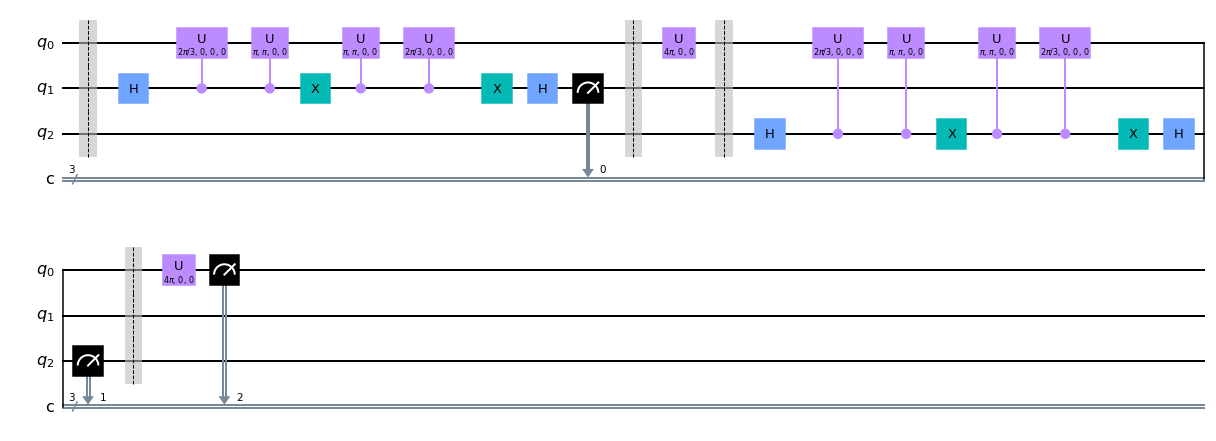

In [5]:
# This example produces a test circuit with quantum operation V and W of gate Q, a target operation U=(W^n) and input/output q0.
# This test circuit works as follows.
# - preparing the state of q0 as |0>. 
# - performing the first gate Q to q0 and getting successfully output q0 if a measurement result of q1 is 1.
# - performing an operation U(=W^n) to q0. (Operation U is inverted by the universal quantum rewinding protocol.)
# - performing the second gate Q to q0 and getting successfully output q0 if a measurement result of q2 is 1.
# - performing an operation of U to q0.
# Therefore, the final state of q0 becomes |0> if the universal quantum rewinding protocol finishes successfully.
qc = qrp_test_qc(0.25, 6)
qc.draw(output="mpl")

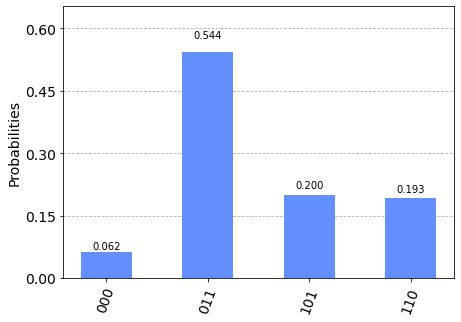

In [6]:
# This test circuit measures output q1 of the first gate Q and output q2 of the second gate Q,
# and obtains one of four possible classical results. (00, 01, 10 and 11)
# If (q1, q2) = (1, 1), the universal quantum rewinding protocol successfully finishes.
# This result shows that,
# - the probability that (q0, q2, q1) becomes (0, 1, 1) is >0.
# - the probability that (q0, q2, q1) becomes (1, 1, 1) is 0.
# It means that q0 becomes |0> and the universal quantum rewinding protocol successfully inverts a quantum operation U(=W^n) if (q1, q2) = (1, 1).
aer_sim = Aer.get_backend("aer_simulator")
job = aer_sim.run(assemble(qc), shots=4096)
result = job.result().get_counts()
plot_histogram(result)

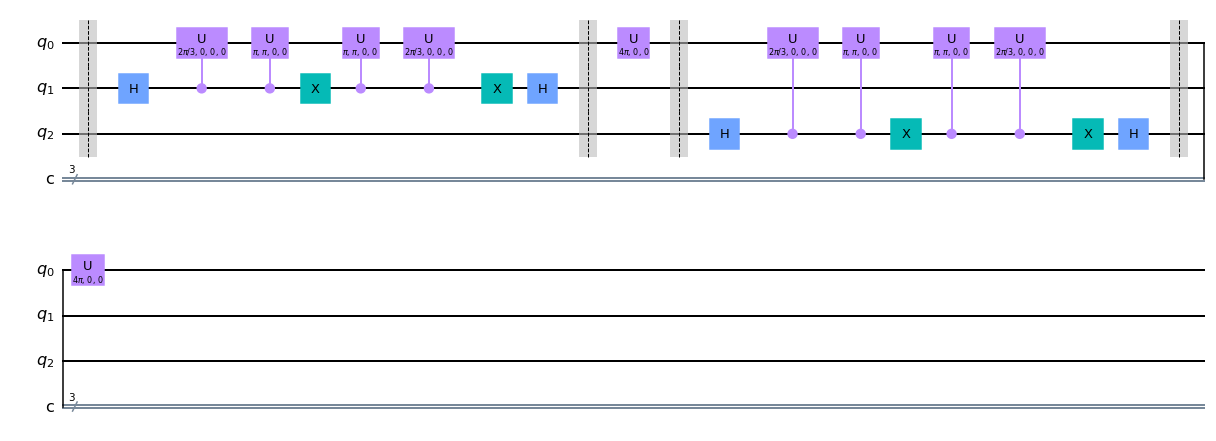

In [7]:
# Another simulation.
# This example calculates the density matrix of the state.
# To calculate the density matrix, the recipient skips the measurement of the state.
qc = qrp_test_qc(0.25, 6, measure_flag=False, qrp_measure_flag=False)
qc.draw(output="mpl")

In [8]:
# This test circuit measures output q1 of the first gate Q and output q2 of the second gate Q,
# and obtains one of four possible classical results. (00, 01, 10 and 11)
sv_simulator = Aer.get_backend('statevector_simulator')
circuit = transpile(qc, backend=sv_simulator)
statevector = sv_simulator.run(circuit).result().data()['statevector']

In [9]:
# This result shows q0 = |0> if (q1, q2) = (1, 1).
# As a result, the universal quantum rewinding protocol successfully finishes if (q1, q2) = (1, 1).
statevec_mean_cond(statevector, [1, 1, None])

((0.5625+0j),
 DensityMatrix([[ 1.00000000e+00+0.0000000e+00j,
                 -2.01265830e-48+8.2173011e-33j],
                [-2.01265830e-48-8.2173011e-33j,
                  6.75240373e-65+0.0000000e+00j]],
               dims=(2,)))